**main script**
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [ ]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

# Deterministic Full Waveform Inversion

In [1]:
from IPython.display import clear_output
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
labelsize = 16

from scipy.optimize import minimize
from func.propagation import prop2d, defmodel
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics.pairwise import pairwise_distances
# print('GPU:',tf.config.list_physical_devices('GPU'))

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import cupy as cp
device = 'cpu'

## Tensorflow mapping function
# def f_tf(u, vmin=2000, vmax=3000):
#     cdf = tfp.distributions.Normal(loc=0, scale=1).cdf(u)
#     # cdf =  tf.math.exp(-tf.math.square(u_tf)) / tf.math.sqrt(2.0 * np.pi)
#     v = (vmax - vmin) * cdf + vmin
#     return v

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v

# def f(u, a=2000, b=3000):
# 	'''
# 	Reparametrization mapping function from u -> v
# 	Unconstrained parameter -> Physical parameter space
# 	'''
# 	v = a+(b-a)/(1+np.exp(-u))

# 	return v


def f_inv(v, a=2000, b=3000):
	'''Inverse of the mapping function f^-1'''
	u = np.log(v-a) - np.log(b-v)

	return u


# Define cost function
def loglik_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
 
	return tf.cast(log_likelihood, tf.float32)

# Calculate gradient with Adjoint state method
def dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	dJ_dv = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)
	dloglik_dv = -dJ_dv / alpha
	dv_du = sc.misc.derivative(f,u)

	return tf.cast(dloglik_dv.flatten() * dv_du.flatten(), tf.float32)

def dlog_prob_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	dloglik_du = dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha)
	dlog_prior_du = -Q.dot(u.flatten())

	return dloglik_du + dlog_prior_du


2023-04-03 13:52:37.967993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 13:52:38.258631: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 13:52:39.388697: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yxie-l/anaconda3/envs/geostat/lib/
2023-04-03 13:52:39.388996: W tensorflow/comp

## Forward modeling

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  29 29 235
Number of receivers: 27


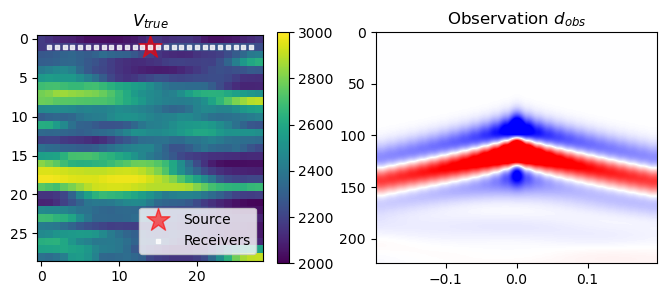

In [59]:
# Model size (nz,nx) = (29,29)
import pickle
# load data
filename = './data/u_29'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_29'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 29,29,235
vmin,vmax=2000,3000
izsrc, ixsrc = [1], [nx//2]
next = 10

# v_ref = gaussian2d(ranges=[20,5],variance=50,nx=[nz,nx],param=1,mean=2500)
# u_ref, Q = gaussian2d(ranges = [20,5],param=1,nx=[nz,nx],variance=1,mean=0)
u_ref = u_ref.flatten()
v_ref = f(u_ref)

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  

# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 1 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx-1,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
zxrec = zxrec1
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
# d_obs = simulate_obs(f(u_ref).resh, wsrc, zxsrc, at, az, ax, next, zxrec)
p = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)
d_obs = p[zxrec[0], zxrec[1], :]

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

## Inversion with prior regularization term

In [60]:
# Define cost function
def objective_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	loss_J = J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
	print("Loss (J) = %.4f " % loss_J, end='')
	# Q: Likelihood part
	u = u.flatten()
	penalty = .5 * u.T.dot(Q.toarray()).dot(u)
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,loss_J,penalty])

	return loss

# Calculate gradient with Adjoint state method
def gradiant_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	return G.flatten()*sc.misc.derivative(f,u).flatten()/ alpha + Q.dot(u.flatten())

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])
	
# minimize cost function
start = time.time()
u_init = np.zeros([nz*nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
loss_tracker = np.empty((0,3))

std_noise = 0.1 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = objective_fwi_prior, 
               x0 = u_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
            #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant_fwi_prior,
               options = {'disp':True, 'maxiter':150},
               callback=callback
              )
u_fwi = resi.x
print(u_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

Loss (J) = 199535.0765 Penalty term = 0.0000 Total loss = 199535.0765 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          841     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99535D+05    |proj g|=  4.05019D+03
Loss (J) = 159558.7027 Penalty term = 0.2699 Total loss = 159558.9726 


 This problem is unconstrained.


Loss (J) = 52147.5700 Penalty term = 6.7470 Total loss = 52154.3170 

At iterate    1    f=  5.21543D+04    |proj g|=  1.80821D+03
Loss (J) = 17960.6003 Penalty term = 14.0674 Total loss = 17974.6677 

At iterate    2    f=  1.79747D+04    |proj g|=  3.93216D+02
Loss (J) = 11494.9893 Penalty term = 12.4578 Total loss = 11507.4471 

At iterate    3    f=  1.15074D+04    |proj g|=  2.87468D+02
Loss (J) = 4072.0373 Penalty term = 9.7125 Total loss = 4081.7498 

At iterate    4    f=  4.08175D+03    |proj g|=  1.62762D+02
Loss (J) = 2384.6590 Penalty term = 8.8628 Total loss = 2393.5218 

At iterate    5    f=  2.39352D+03    |proj g|=  1.33058D+02
Loss (J) = 1726.4252 Penalty term = 10.1514 Total loss = 1736.5766 

At iterate    6    f=  1.73658D+03    |proj g|=  9.92310D+01
Loss (J) = 1383.6978 Penalty term = 10.9817 Total loss = 1394.6795 

At iterate    7    f=  1.39468D+03    |proj g|=  1.04061D+02
Loss (J) = 980.3566 Penalty term = 12.4077 Total loss = 992.7643 

At iterate    8    f


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 1725.9694 Penalty term = 11.8296 Total loss = 1737.7989 
Loss (J) = 318.5226 Penalty term = 11.4481 Total loss = 329.9707 

At iterate   32    f=  3.29971D+02    |proj g|=  1.30021D+01
Loss (J) = 310.9922 Penalty term = 11.3117 Total loss = 322.3039 

At iterate   33    f=  3.22304D+02    |proj g|=  1.49851D+01
Loss (J) = 295.4382 Penalty term = 10.9626 Total loss = 306.4008 

At iterate   34    f=  3.06401D+02    |proj g|=  1.37054D+01
Loss (J) = 282.0449 Penalty term = 10.5871 Total loss = 292.6320 

At iterate   35    f=  2.92632D+02    |proj g|=  1.45122D+01
Loss (J) = 274.5682 Penalty term = 10.4548 Total loss = 285.0230 

At iterate   36    f=  2.85023D+02    |proj g|=  7.71782D+00
Loss (J) = 270.5806 Penalty term = 10.3198 Total loss = 280.9004 

At iterate   37    f=  2.80900D+02    |proj g|=  1.12717D+01
Loss (J) = 263.8683 Penalty term = 10.1414 Total loss = 274.0097 

At iterate   38    f=  2.74010D+02    |proj g|=  1.52401D+01
Loss (J) = 254.3960 Penalty term = 1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 663584.1596 Penalty term = 1322.3571 Total loss = 664906.5168 
Loss (J) = 25.4868 Penalty term = 11.3154 Total loss = 36.8021 

At iterate  102    f=  3.68021D+01    |proj g|=  8.86605D+00
Loss (J) = 24.4597 Penalty term = 11.3085 Total loss = 35.7681 

At iterate  103    f=  3.57681D+01    |proj g|=  3.72751D+00
Loss (J) = 24.1823 Penalty term = 11.2895 Total loss = 35.4719 

At iterate  104    f=  3.54719D+01    |proj g|=  3.65477D+00
Loss (J) = 24.0431 Penalty term = 11.2363 Total loss = 35.2794 

At iterate  105    f=  3.52794D+01    |proj g|=  3.38315D+00
Loss (J) = 24.0935 Penalty term = 11.1622 Total loss = 35.2557 

At iterate  106    f=  3.52557D+01    |proj g|=  3.43606D+00
Loss (J) = 24.1350 Penalty term = 10.9998 Total loss = 35.1349 

At iterate  107    f=  3.51349D+01    |proj g|=  3.88249D+00
Loss (J) = 24.5074 Penalty term = 10.7415 Total loss = 35.2489 
Loss (J) = 24.0642 Penalty term = 10.9193 Total loss = 34.9835 

At iterate  108    f=  3.49835D+01    |pr


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 22.6408 Penalty term = 10.4171 Total loss = 33.0579 

At iterate  116    f=  3.30579D+01    |proj g|=  1.76721D+00
Loss (J) = 22.6398 Penalty term = 10.3926 Total loss = 33.0324 

At iterate  117    f=  3.30324D+01    |proj g|=  2.11253D+00
Loss (J) = 22.6867 Penalty term = 10.3619 Total loss = 33.0487 
Loss (J) = 22.6419 Penalty term = 10.3858 Total loss = 33.0277 
Loss (J) = 22.6650 Penalty term = 10.3699 Total loss = 33.0349 
Loss (J) = 22.6445 Penalty term = 10.3825 Total loss = 33.0271 

At iterate  118    f=  3.30271D+01    |proj g|=  1.95432D+00
Loss (J) = 22.8439 Penalty term = 10.2728 Total loss = 33.1167 
Loss (J) = 22.6368 Penalty term = 10.3552 Total loss = 32.9920 

At iterate  119    f=  3.29920D+01    |proj g|=  1.18541D+00
Loss (J) = 23.6995 Penalty term = 10.1480 Total loss = 33.8475 
Loss (J) = 22.6580 Penalty term = 10.3235 Total loss = 32.9816 

At iterate  120    f=  3.29816D+01    |proj g|=  1.43822D+00
Loss (J) = 23.8091 Penalty term = 10.0961 Total lo


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 22.6053 Penalty term = 10.2803 Total loss = 32.8855 

At iterate  122    f=  3.28855D+01    |proj g|=  1.01131D+00
Loss (J) = 22.5818 Penalty term = 10.2705 Total loss = 32.8523 

At iterate  123    f=  3.28523D+01    |proj g|=  1.19275D+00
Loss (J) = 22.6021 Penalty term = 10.2277 Total loss = 32.8298 

At iterate  124    f=  3.28298D+01    |proj g|=  1.66375D+00
Loss (J) = 22.7501 Penalty term = 10.1403 Total loss = 32.8905 
Loss (J) = 22.6172 Penalty term = 10.2108 Total loss = 32.8280 
Loss (J) = 22.6926 Penalty term = 10.1638 Total loss = 32.8564 
Loss (J) = 22.6271 Penalty term = 10.2023 Total loss = 32.8294 

At iterate  125    f=  3.28294D+01    |proj g|=  1.73526D+00
Loss (J) = 23.3734 Penalty term = 9.9349 Total loss = 33.3083 
Loss (J) = 22.6778 Penalty term = 10.1583 Total loss = 32.8361 
Loss (J) = 22.6359 Penalty term = 10.1931 Total loss = 32.8290 
Loss (J) = 22.6621 Penalty term = 10.1700 Total loss = 32.8321 
Loss (J) = 22.6407 Penalty term = 10.1884 Total l


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 54147.7703 Penalty term = 284.3194 Total loss = 54432.0897 
Loss (J) = 23.1803 Penalty term = 9.3853 Total loss = 32.5655 

At iterate  137    f=  3.25655D+01    |proj g|=  1.02861D+00
Loss (J) = 23.0271 Penalty term = 9.3754 Total loss = 32.4024 

At iterate  138    f=  3.24024D+01    |proj g|=  1.39398D+00
Loss (J) = 22.6252 Penalty term = 9.3455 Total loss = 31.9707 

At iterate  139    f=  3.19707D+01    |proj g|=  3.26339D+00
Loss (J) = 22.1230 Penalty term = 9.2960 Total loss = 31.4190 
Loss (J) = 22.2467 Penalty term = 9.3183 Total loss = 31.5650 

At iterate  140    f=  3.15650D+01    |proj g|=  2.84354D+00
Loss (J) = 22.0192 Penalty term = 9.3023 Total loss = 31.3215 

At iterate  141    f=  3.13215D+01    |proj g|=  1.44662D+00
Loss (J) = 21.7934 Penalty term = 9.2806 Total loss = 31.0740 

At iterate  142    f=  3.10740D+01    |proj g|=  1.80546D+00
Loss (J) = 21.7220 Penalty term = 9.2746 Total loss = 30.9967 

At iterate  143    f=  3.09967D+01    |proj g|=  1.7


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


## FWI result

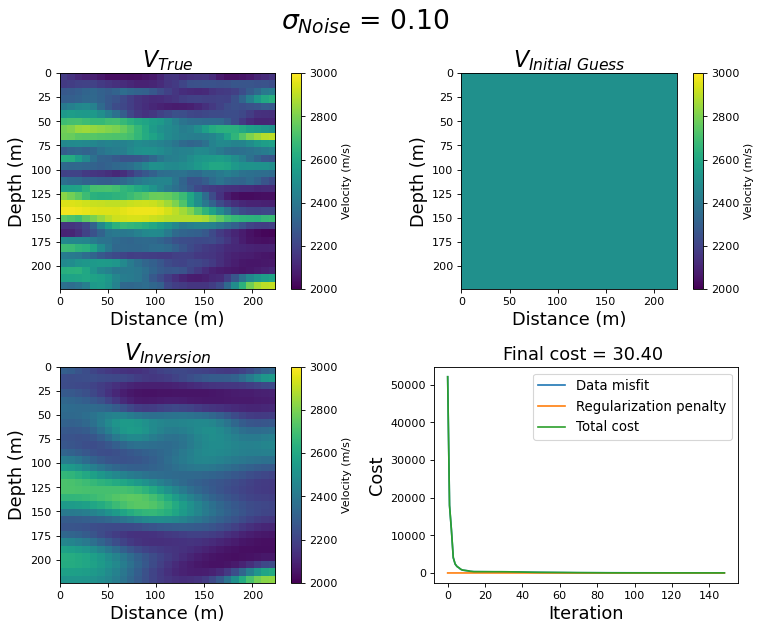

In [61]:
# Plot deterministic FWI result and optimization history
v_fwi = f(u_fwi)

plt.figure(figsize=(10,8),dpi=80)
plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.subplot(2,2,1) 
plt.imshow(v_ref.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{True}$",fontsize=labelsize+4)
plt.subplot(2,2,2) 
plt.imshow(v_init.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
plt.subplot(2,2,3)
plt.imshow(v_fwi.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
plt.title("$V_{Inversion}$",fontsize=labelsize+4)
plt.subplot(2,2,4)
plt.title("Final cost = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.plot(loss_tracker[:,1],label="Data misfit")
plt.plot(loss_tracker[:,2],label="Regularization penalty")
plt.plot(loss_tracker[:,0],label="Total cost")
plt.xlabel("Iteration",fontsize=labelsize)
plt.ylabel("Cost",fontsize=labelsize)
# plt.xlim(0,150)
# plt.ylim(0,800)
plt.legend(fontsize=labelsize-4)
plt.tight_layout()
plt.show()

# SVGD

In [ ]:
import multiprocessing

def compute_loglik_fn(u):
    # your implementation of loglik_fn here
    return loglik_fn(u.numpy(),d_obs,*args)
    # return -0

def compute_dloglik_du_fn(u):
    # your implementation of dloglik_du_fn here
    return dloglik_du_fn(u.numpy(),d_obs,*args)

def compute_parallel(u_samples, num_processes=4):
    with multiprocessing.Pool(processes=num_processes) as pool:
        log_likelihoods = pool.map(compute_loglik_fn, u_samples)
        grads_log_likelihoods = pool.map(compute_dloglik_du_fn, u_samples)
    return log_likelihoods, grads_log_likelihoods

args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)

# Define the prior distribution for the model parameters
prior_mean = tf.zeros(nz*nx, dtype=tf.float32)
prior_cov = tf.cast(sc.sparse.linalg.inv(Q).toarray(), tf.float32)
prior_scale_tril = tf.cast(tf.linalg.cholesky(prior_cov), tf.float32)
p_dist = tfp.distributions.MultivariateNormalTriL(loc=prior_mean, scale_tril=prior_scale_tril)
prior_scale = p_dist.stddev()

# Define the TensorFlow variables for the variational posterior particles
num_particles = 841
N = tf.cast(num_particles, dtype=tf.float32)
q_particles_init = tf.random.normal(shape=(num_particles, nz*nx), dtype=tf.float32)
q_particles = tf.Variable(q_particles_init, dtype=tf.float32)

# Set up lists to store progress
neg_loglik_history = []
kl_history = []
misfit_history = []

optimizer = tf.keras.optimizers.Adam()

In [ ]:
optimizer.learning_rate = 0.1

# Set hyper-parameters
std_noise = 0.1
print(f"Learning Rate: {optimizer.learning_rate.numpy()}")

# Train the variational posterior using the ELBO objective
num_iters = 50
alpha = 5  # learning rate for updating the particles

for i in range(num_iters):
  # Print the iteration number
  print(f"Iteration {i + 1}/{num_iters}", end="    ")

  with tf.GradientTape() as tape:
    # Watch the parameters of the variational posterior
    tape.watch(q_particles)
    
    ## Compute the SVGD kernel matrix and its gradient
    with tf.GradientTape() as tape2:
      rbf_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=1.0)
      svgd_kernel_matrix = rbf_kernel.matrix(q_particles, q_particles)
      grads_kernal_matrix = tape2.gradient(svgd_kernel_matrix, q_particles)

    q_mean = tf.reduce_mean(q_particles, axis=0)
    q_cov = tfp.stats.covariance(q_particles) + 1e-5 * tf.eye(nz*nx, dtype=tf.float32)
    # if tf.linalg.det(q_cov)==0: print(" * Warning: Numerically Unstable    det(q_cov)=0")
    q_dist = tfp.distributions.MultivariateNormalTriL(q_mean, tf.linalg.cholesky(q_cov))
    misfit = J(f(q_mean.numpy()),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
    
    print("J = %.2f" % misfit)
    misfit_history.append(misfit)

    # Compute the log(d_obs|v) log-likelihood and its gradient
    log_likelihoods = []
    grads_log_likelihoods = []

    # Calculate the gradient of the log-likelihoods
    log_likelihoods, grads_log_likelihoods = compute_parallel(q_particles, num_processes=8)
    # for u in q_particles:
    #   log_likelihoods.append(loglik_fn(u.numpy(), d_obs, *args))
    #   grads_log_likelihoods.append(dloglik_du_fn(u.numpy(), d_obs, *args))

    # Compute E[log likelihood] and its gradient
    # E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
    # grads_E_log_likelihoods = tf.cast(tf.reduce_mean(grads_log_likelihoods, axis=0), dtype=tf.float32)

    # Compute the KL(q||p) term 
    kl_divergence_q_p = tfp.distributions.kl_divergence(q_dist, p_dist)
    grads_kl_divergence_q_p = tape.gradient(kl_divergence_q_p, q_particles)
    
    # Compute the SVGD update for each particle
    # svgd_update = tf.matmul(svgd_kernel_matrix, grads_log_likelihoods) / N  - grads_kl_divergence_q_p
    grads_svgd = -tf.matmul(svgd_kernel_matrix, grads_log_likelihoods) / N  \
                  + grads_kl_divergence_q_p  \
                  + grads_kernal_matrix / N

    # Apply the SVGD update to the particles
    # q_particles = q_particles + alpha * svgd_update
    optimizer.apply_gradients(zip([grads_svgd], [q_particles]))

    # Clip the particle positions to avoid NaNs
    # q_particles = tf.clip_by_value(q_particles, -1e4, 1e4)
    

# SVGD - Prob

In [81]:
import multiprocessing

def compute_dlog_prob_du_fn(u):
    # your implementation of dloglik_du_fn here
    return dlog_prob_du_fn(u.numpy(),d_obs,*args)
    # return tf.cast(gradiant_fwi_prior(u.numpy(),d_obs,*args), tf.float32)

def compute_parallel(u_samples, num_processes=4):
    with multiprocessing.Pool(processes=num_processes) as pool:
        grads_log_prob = pool.map(compute_dlog_prob_du_fn, u_samples)
    return grads_log_prob

# Define the TensorFlow variables for the variational posterior particles
num_particles = 100
N = tf.cast(num_particles, dtype=tf.float32)

# Sample from the prior distribution with precision matrix Q to initialize particles
p_mean = tf.zeros(nz*nx, dtype=tf.float32)
# p_mean = tf.convert_to_tensor(u_fwi, dtype=tf.float32)
p_cov = tf.cast(sc.sparse.linalg.inv(Q).toarray(), tf.float32)
p_dist = tfp.distributions.MultivariateNormalTriL(loc=p_mean, scale_tril=tf.linalg.cholesky(p_cov))
q_particles = tf.Variable(p_dist.sample(num_particles), dtype=tf.float32)

# Set up lists to store progress
misfit_history = []

# optimizer = tf.keras.optimizers.Adam()
optimizer = tf.optimizers.Adagrad()

del(p_cov)

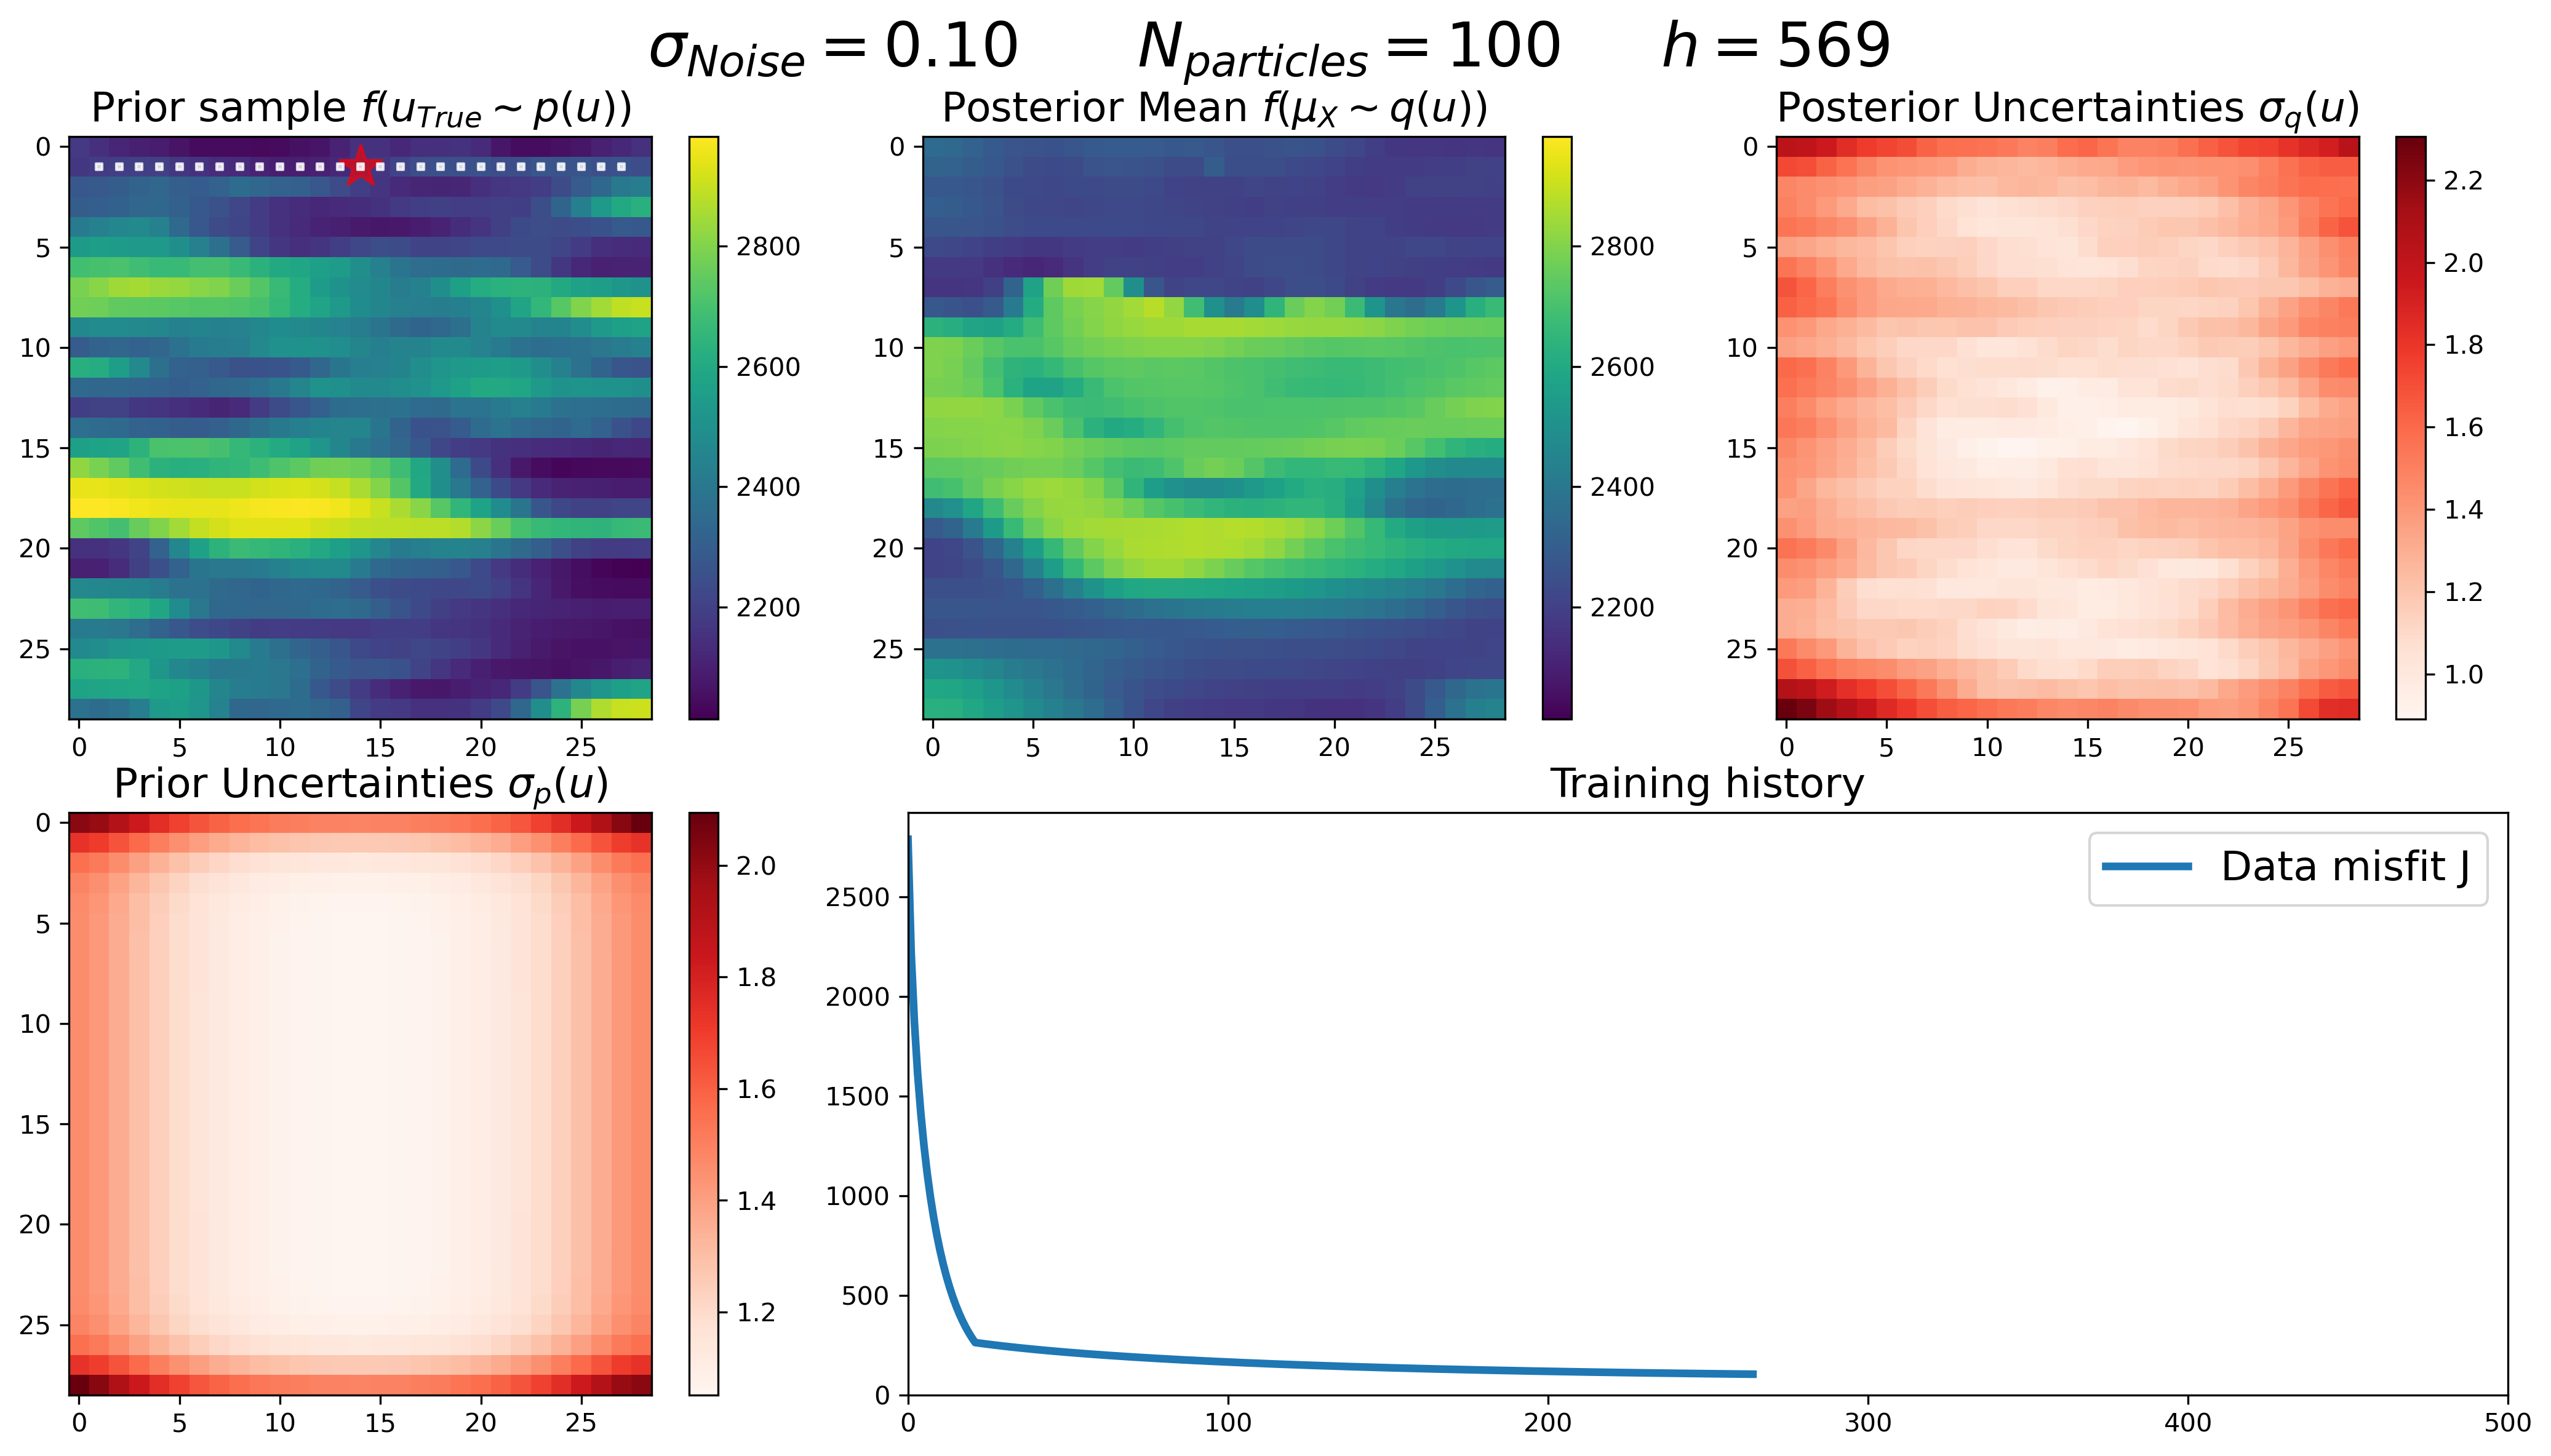

Iteration 266/500    J = 104.29


In [82]:
# ===============================================================================================
# Set hyper-parameters
optimizer.learning_rate = 0.1
std_noise = 0.1
args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)
print(f"Learning Rate: {optimizer.learning_rate.numpy()}")

# Train the variational posterior using the ELBO objective
num_iters = 500

for i in range(num_iters):
  # Print the iteration number
  print(f"Iteration {i + 1}/{num_iters}", end="    ")

  with tf.GradientTape() as tape:
    # Watch the parameters of the variational posterior
    tape.watch(q_particles)
  
    ## Compute the SVGD kernel matrix and its gradient  Cost: O(n^2)
    with tf.GradientTape() as tape2:
      # Compute pairwise distances between all the current particles
      med = np.median(pairwise_distances(q_particles))
      h = med**2/np.log(num_particles)  # Set bandwidth parameter h to be med^2 / log(n)
      # h = med/np.sqrt(2*np.log(num_particles))

      rbf_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=float(h))
      svgd_kernel_matrix = rbf_kernel.matrix(q_particles, q_particles)
      grads_kernal_matrix = tape2.gradient(svgd_kernel_matrix, q_particles)

    q_mean = tf.reduce_mean(q_particles, axis=0)
    misfit = J(f(q_mean.numpy()),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
    print("J = %.2f" % misfit)
    misfit_history.append(misfit)

    # Compute the log(d_obs|v) log-likelihood and its gradient
    log_likelihoods = []
    grads_log_likelihoods = []
    
    # Calculate the gradient of the log-likelihoods
    grads_log_prob = []
    # for u in q_particles: grads_log_prob.append(compute_dlog_prob_du_fn(u))
    grads_log_prob = compute_parallel(q_particles, num_processes=8)

    # Compute the SVGD update for each particle
    update_svgd = (tf.matmul(svgd_kernel_matrix, grads_log_prob) + grads_kernal_matrix) / N
    # update_svgd = tf.convert_to_tensor(grads_log_prob)
    grads_svgd = - update_svgd
    # Apply the SVGD update to the particles
    optimizer.apply_gradients(zip([grads_svgd], [q_particles]))
    if i==20: optimizer.learning_rate = 0.01
    clear_output(wait=True)

    display_particles(q_particles, q_mean)



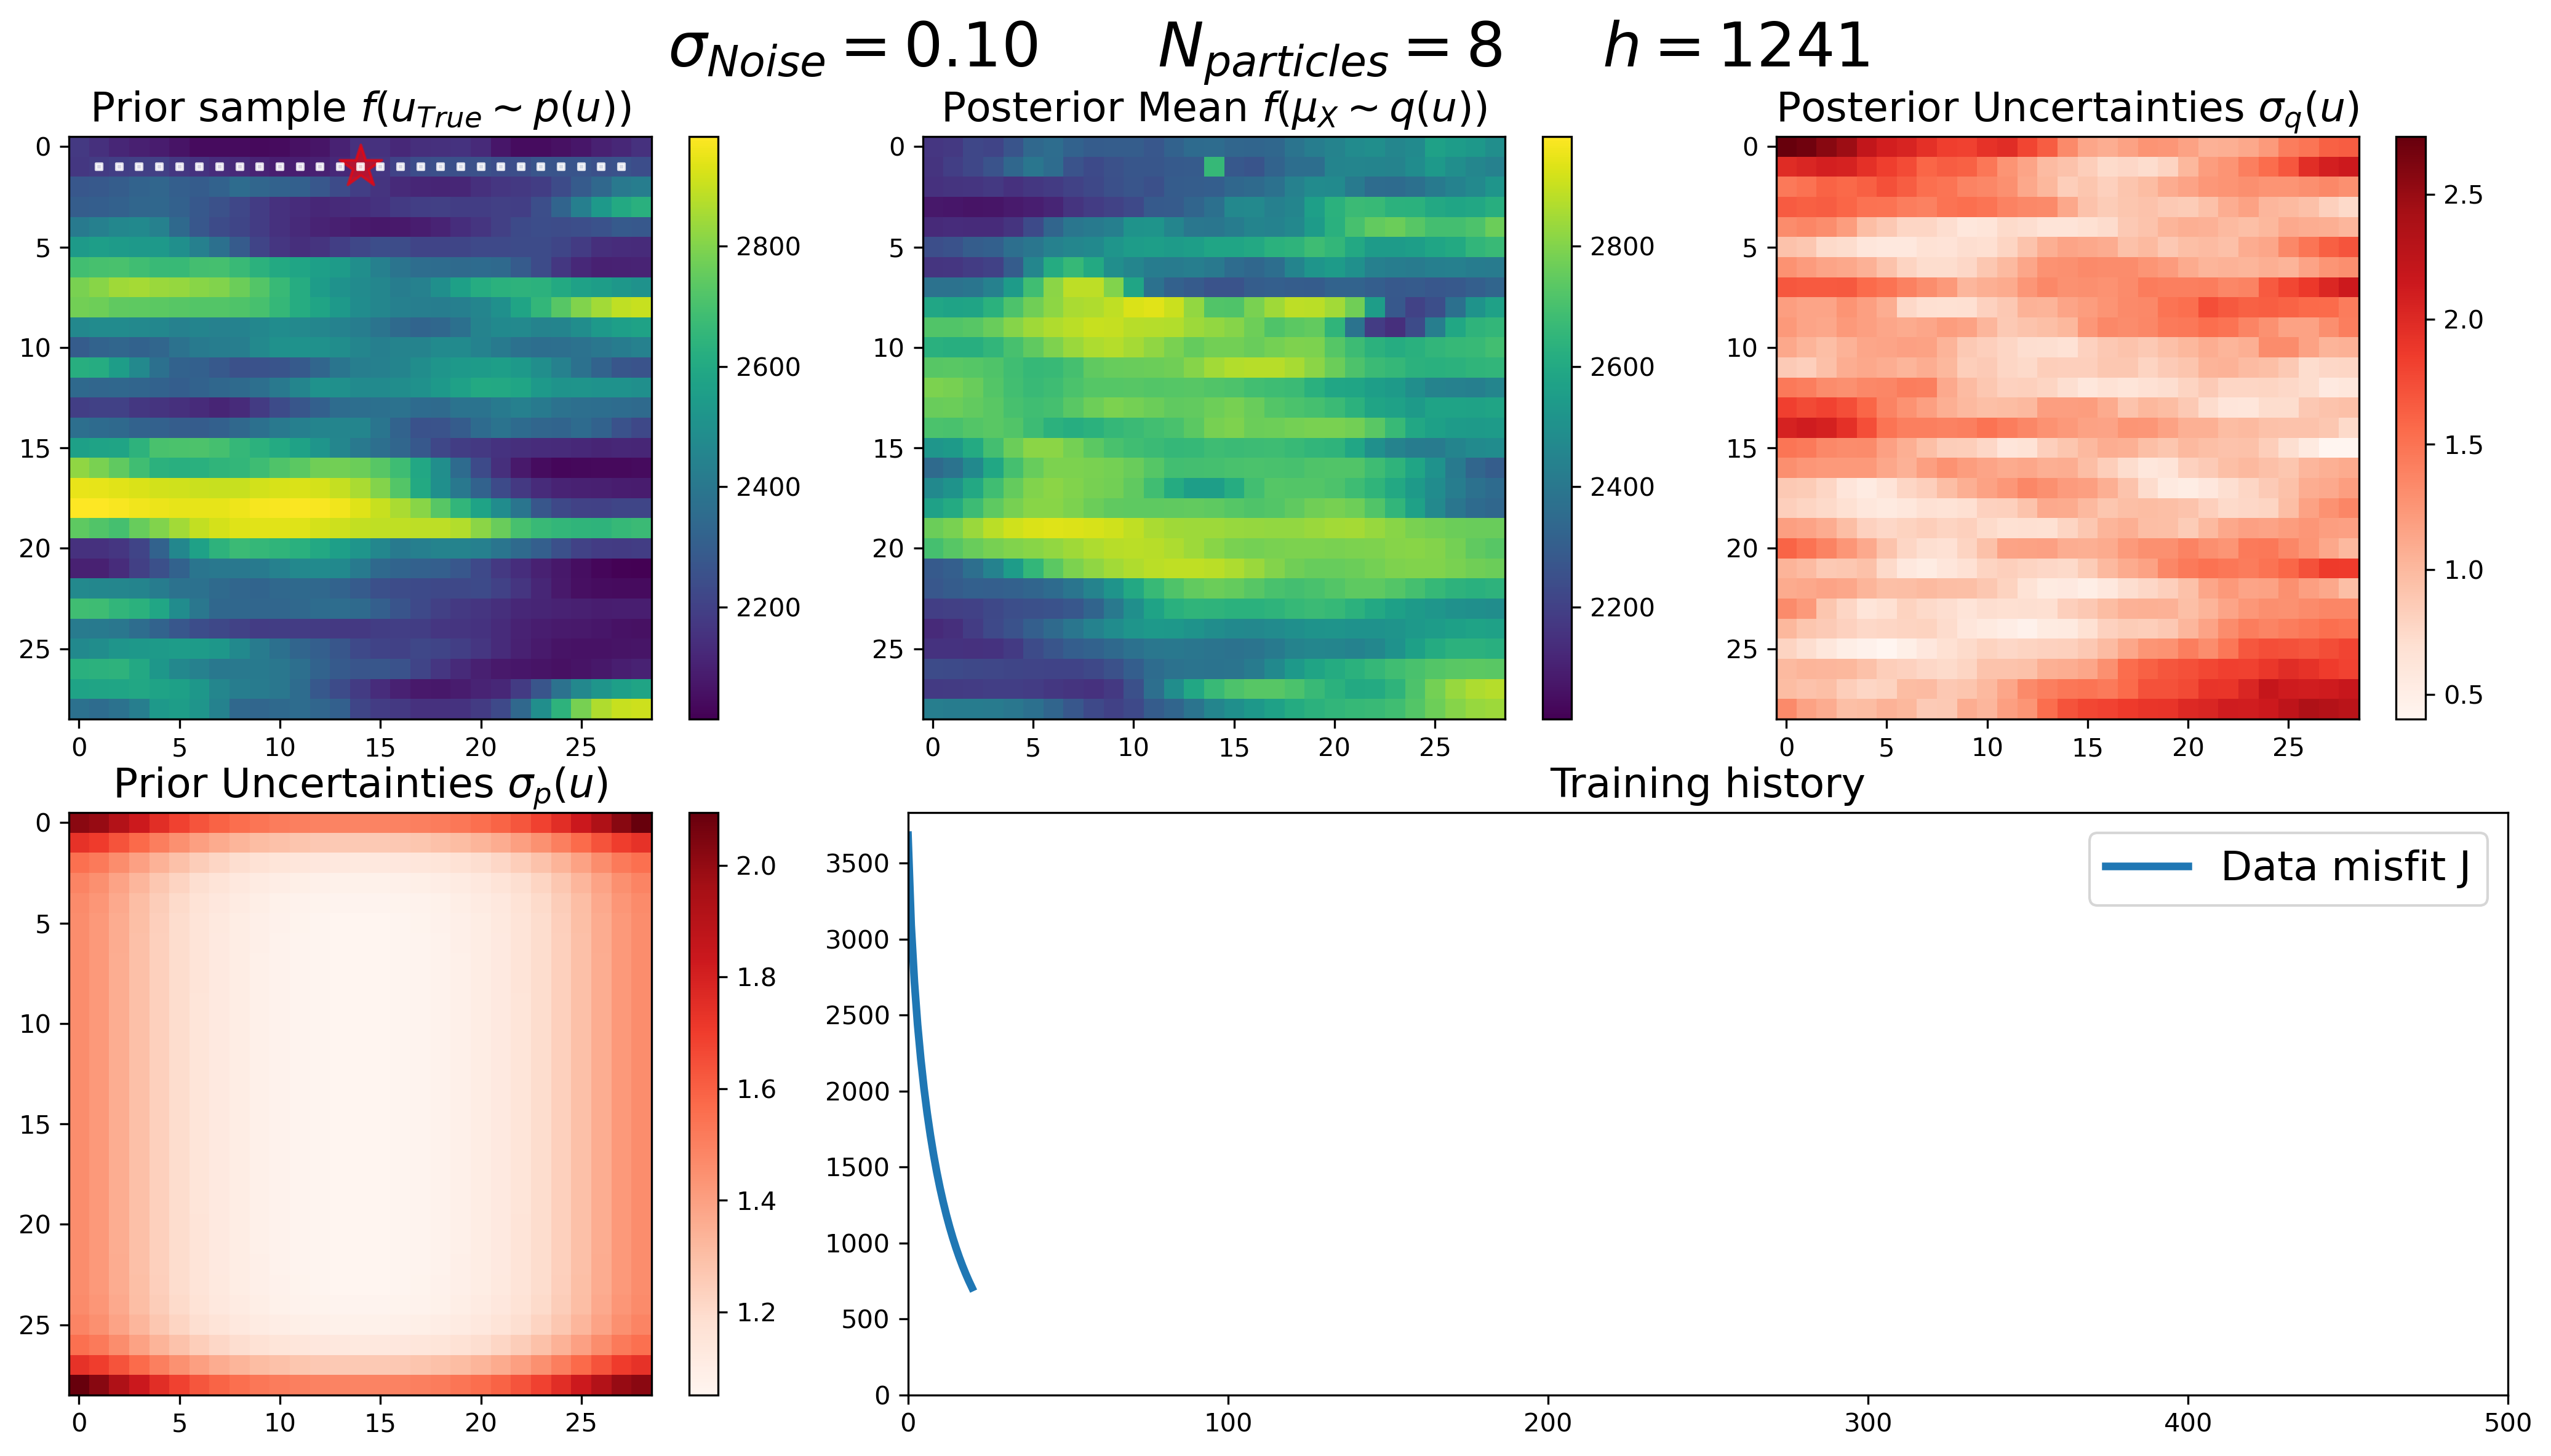

In [76]:
# q_mean = tf.reduce_mean(q_particles, axis=0)
def display_particles(q_particles, q_mean):

  vmin, vmax = f(u_ref).min(), f(u_ref).max()

  plt.figure(figsize=(14,8), dpi=300)
  plt.suptitle("$\sigma_{Noise}=$%.2f  " % std_noise + \
              "    $N_{particles}=$"+str(num_particles)+
              "     $h=$"+str(int(h)),
              fontsize=labelsize+8)

  plt.subplot(2,3,1)
  plt.imshow(f(u_ref).reshape((nz,nx)),vmin=vmin, vmax=vmax)
  plt.colorbar()
  plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
  plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
  plt.title("Prior sample $f(u_{True} \sim p(u))$", fontsize=16)

  plt.subplot(2,3,2)
  plt.imshow(f(q_mean.numpy()).reshape((nz,nx)),vmin=vmin, vmax=vmax)
  plt.colorbar()
  plt.title("Posterior Mean $f(\mu_{X} \sim q(u))$", fontsize=16)

  plt.subplot(2,3,3)
  plt.imshow(tf.reshape(tfp.stats.stddev(q_particles),[nz,nx]),cmap='Reds')
  plt.colorbar()
  plt.title("Posterior Uncertainties $\sigma_{q}(u)$", fontsize=16)

  plt.subplot(2,3,4)
  plt.imshow(tf.reshape(p_dist.stddev(),[nz,nx]),cmap='Reds')
  plt.colorbar()
  plt.title("Prior Uncertainties $\sigma_{p}(u)$", fontsize=16)

  plt.subplot(2,3,(5,6))
  plt.plot(misfit_history, label='Data misfit J', lw=3)
  plt.xlim(0, 500*(len(misfit_history)//500+1))
  plt.ylim(bottom=0)
  plt.title("Training history", fontsize=16)
  plt.legend(fontsize=16)

  plt.tight_layout()
  plt.show()

display_particles(q_particles, q_mean)

In [51]:
400//500

0

In [52]:
500*(len(misfit_history)//500+1)

1000

## Mini-batch

In [ ]:
import multiprocessing

def compute_dlog_prob_du_fn(u):
    # your implementation of dloglik_du_fn here
    return dlog_prob_du_fn(u.numpy(),d_obs,*args)

def compute_parallel(u_samples, num_processes=4):
    with multiprocessing.Pool(processes=num_processes) as pool:
        grads_log_prob = pool.map(compute_dlog_prob_du_fn, u_samples)
    return grads_log_prob

args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)

# Define the TensorFlow variables for the variational posterior particles
num_particles = 841
N = tf.cast(num_particles, dtype=tf.float32)

# Sample from the prior distribution with precision matrix Q to initialize particles
p_mean = tf.zeros(nz*nx, dtype=tf.float32)
p_cov = tf.cast(sc.sparse.linalg.inv(Q).toarray(), tf.float32)
p_dist = tfp.distributions.MultivariateNormalTriL(loc=p_mean, scale_tril=tf.linalg.cholesky(p_cov))
q_particles_init = p_dist.sample(num_particles)
q_particles = tf.Variable(q_particles_init, dtype=tf.float32)

# Set up lists to store progress
misfit_history = []

optimizer = tf.keras.optimizers.Adam()
optimizer.learning_rate = 0.1

# ===============================================================================================
# Set hyper-parameters
std_noise = 0.1
batch_size = 64  # number of particles in each mini-batch
num_batches = num_particles // batch_size  # number of mini-batches

print(f"Learning Rate: {optimizer.learning_rate.numpy()}")

# Train the variational posterior using the ELBO objective
num_iters = 50
alpha = 5  # learning rate for updating the particles

for i in range(num_iters):
  # Print the iteration number
  print(f"Iteration {i + 1}/{num_iters}", end="    ")

  with tf.GradientTape() as tape:
    # Watch the parameters of the variational posterior
    tape.watch(q_particles)

    misfit = 0
    
    # Compute the SVGD kernel matrix and its gradient for each mini-batch of particles
    for j in range(num_batches):
      # Select the current mini-batch of particles
      q_particles_batch = q_particles[j*batch_size:(j+1)*batch_size]
      
      # Compute pairwise distances between the current mini-batch and all particles
      med = np.median(pairwise_distances(q_particles_batch, q_particles))
      h = med**2/np.log(num_particles)  # Set bandwidth parameter h to be med^2 / log(n)

      ## Compute the SVGD kernel matrix and its gradient for the current mini-batch
      with tf.GradientTape() as tape2:
        rbf_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=float(h))
        svgd_kernel_matrix = rbf_kernel.matrix(q_particles_batch, q_particles)
        grads_kernal_matrix = tape2.gradient(svgd_kernel_matrix, q_particles_batch)

      # Compute the log(d_obs|v) log-likelihood and its gradient for the current mini-batch
      grads_log_prob = compute_parallel(q_particles_batch, num_processes=8)
      log_likelihoods = [J(f(q_particle.numpy()),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) for q_particle in q_particles_batch]
      
      # Compute the SVGD update for the current mini-batch
      update_svgd = (tf.matmul(svgd_kernel_matrix, grads_log_prob) + grads_k


In [ ]:
vmin, vmax = f(u_ref).min(), f(u_ref).max()
plt.imshow(f(q_mean.numpy()).reshape((nz,nx)),vmin=vmin, vmax=vmax)

In [ ]:
plt.imshow(tf.reshape(tfp.stats.stddev(q_particles),[nz,nx]),cmap='Reds')
plt.colorbar()

In [ ]:
plt.plot(misfit_history, label='J')
plt.title("Training history", fontsize=16)
plt.legend()
plt.show()

In [ ]:
# Define the TensorFlow variables for the variational posterior particles
num_particles = 100
q_particles_init = tf.random.normal(shape=(num_particles, nz*nx), dtype=tf.float32)
q_particles = tf.Variable(q_particles_init, dtype=tf.float32)

## Compute the SVGD kernel matrix and its gradient
rbf_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=1.0)
svgd_kernel_matrix = rbf_kernel.matrix(q_particles, q_particles)

# Add a small jitter term to make the matrix numerically stable
jitter = 1e-6
num_particles = 100
svgd_kernel_matrix += jitter * tf.eye(num_particles)

tf.linalg.cholesky(svgd_kernel_matrix)


In [ ]:
# Exapmle code
for i in range(num_iters):
  # Print the iteration number
  print(f"Iteration {i + 1}/{num_iters}")
  
  with tf.GradientTape() as tape:
    # Watch the parameters of the variational posterior
    tape.watch(q_particles)
    
    # Compute the SVGD kernel matrix and its gradient
    q_gradients = tape.gradient(q_particles, q_particles)
    # svgd_kernel_matrix = svgd_kernel(q_particles, q_gradients)
    rbf_kernel = tfp.math.psd_kernels.RBF(length_scale=1.0)
    svgd_kernel_matrix = rbf_kernel.matrix(q_particles, q_particles)
    grads_svgd_kernel_matrix = tape.gradient(svgd_kernel_matrix, q_particles)

    # Compute the log(d_obs|v) log-likelihood and its gradient
    log_likelihoods = []
    grads_log_likelihoods = []
        
    # Compute the gradient of u with respect to the particles
    with tf.GradientTape() as tape2:
      tape2.watch(q_particles)
      u_samples = q_particles
      du_dq = tape2.gradient(u_samples, q_particles)
    
    # Calculate the gradient of the log-likelihoods
    for u in u_samples:
      log_likelihoods.append(loglik_fn(u.numpy(), d_obs, *args))
      grads_log_likelihoods.append(dloglik_du_fn(u.numpy(), d_obs, *args))
    
    # Compute E[log likelihood] and its gradient
    E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
    grads_E_log_likelihoods = tf.cast(tf.reduce_mean(grads_log_likelihoods, axis=0) * du_dq, dtype=tf.float32)

    # Compute the KL(q||p) term 
    kl_divergence_q_p = tfp.distributions.kl_divergence(
        tfp.distributions.MultivariateNormalDiag(loc=q_particles, scale_diag=q_scale), p_dist)
    grads_kl_divergence_q_p = tape.gradient(kl_divergence_q_p, q_particles)

